In [52]:
!pip install catboost

In [53]:
!pip install optuna

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [55]:
df_train_est_A = pd.read_csv('train_est_A.csv')
df_train_obs_A = pd.read_csv('train_obs_A.csv')
df_test_A = pd.read_csv('X_test_A.csv')
df_train_est_A = df_train_est_A.rename(columns={'Unnamed: 0': 'date_forecast'})

df_train_obs_A = df_train_obs_A.rename(columns={'Unnamed: 0': 'date_forecast'})

df_test_A = df_test_A.rename(columns={'Unnamed: 0': 'date_forecast'})

df_train_est_A.set_index('date_forecast', inplace=True)
df_train_obs_A.set_index('date_forecast', inplace=True)
df_test_A.set_index('date_forecast', inplace=True)
df_train_obs_A.index = pd.to_datetime(df_train_obs_A.index)
df_train_obs_A.index = pd.to_datetime(df_train_obs_A.index)

In [56]:
df_train_obs_A=df_train_obs_A.drop(columns=['snow_density:kgm3'])
df_train_est_A=df_train_est_A.drop(columns=['snow_density:kgm3','date_calc'])


In [57]:
df_train_obs_A = df_train_obs_A.fillna(0)
df_train_est_A = df_train_est_A.fillna(0)
df = pd.concat([df_train_obs_A,df_train_est_A])
df.index = pd.to_datetime(df.index)
df['hours'] = df.index.hour
df['day'] = df.index.day
df['month'] = df.index.month
df['year'] = df.index.year
df_test_A.index = pd.to_datetime(df_test_A.index)
df_test_A['hours'] = df_test_A.index.hour
df_test_A['day'] = df_test_A.index.day
df_test_A['month'] = df_test_A.index.month
df_test_A['year'] = df_test_A.index.year
df_test_A = df_test_A.drop(columns = 'date_calc', axis = 1)

In [58]:
import catboost
from catboost import CatBoostRegressor, Pool

model = CatBoostRegressor()

In [59]:
X_train = df.drop(columns = 'pv_measurement')
y_train = df['pv_measurement']

In [60]:
model.fit(X_train,y_train)

Learning rate set to 0.071503
0:	learn: 1101.2410600	total: 45.4ms	remaining: 45.3s
1:	learn: 1041.3165530	total: 69.4ms	remaining: 34.6s
2:	learn: 986.8437623	total: 187ms	remaining: 1m 2s
3:	learn: 936.0732619	total: 293ms	remaining: 1m 12s
4:	learn: 890.0819484	total: 423ms	remaining: 1m 24s
5:	learn: 847.3517614	total: 525ms	remaining: 1m 27s
6:	learn: 808.5827538	total: 602ms	remaining: 1m 25s
7:	learn: 773.4987566	total: 650ms	remaining: 1m 20s
8:	learn: 740.0385762	total: 684ms	remaining: 1m 15s
9:	learn: 710.6539790	total: 719ms	remaining: 1m 11s
10:	learn: 683.7971324	total: 750ms	remaining: 1m 7s
11:	learn: 659.6170861	total: 790ms	remaining: 1m 5s
12:	learn: 638.4855320	total: 824ms	remaining: 1m 2s
13:	learn: 618.5260893	total: 862ms	remaining: 1m
14:	learn: 600.5353672	total: 899ms	remaining: 59.1s
15:	learn: 583.8077678	total: 938ms	remaining: 57.7s
16:	learn: 569.2367694	total: 981ms	remaining: 56.7s
17:	learn: 556.2353119	total: 1.02s	remaining: 55.9s
18:	learn: 544.177

In [61]:
feature_importance = model.feature_importances_
# Define a threshold for feature importance
threshold = 0.0005  # Adjust this value as needed

# Create a DataFrame to store feature importance
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})
# Filter features above the threshold
selected_features = feature_importance_df[feature_importance_df['Importance'] >= threshold]['Feature']

# Create a new DataFrame with the selected features
X_selected = X_train[selected_features]
X_selected['pv_measurement'] = df['pv_measurement']


In [62]:
from sklearn.neighbors import LocalOutlierFactor
df = X_selected
# Crea un modello di rilevamento delle anomalie
clf = LocalOutlierFactor(n_neighbors=20)

# Identifica i dati anomali
anomalies = clf.fit_predict(df)
df[anomalies == -1]
# Stampa i dati anomali
df = df[anomalies != -1]

In [63]:
import pandas as pd
import catboost
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor, Pool

# Sample DataFrame (replace this with your own dataset)
data = df

# Define the number of splits (e.g., 5 for 80-20 train-test splits)
n_splits = 3


# Initialize the TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=n_splits)


In [64]:
def objective(trial):

    # Define the parameters
    params = {
    'iterations': 1000,
    'depth': trial.suggest_int('depth', 1, 10),
    'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
    "subsample": trial.suggest_float("subsample", 0.05, 1.0),
    "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
    "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    #'12_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.01, 10.0),
    #'model_size_reg':trial.suggest_loguniform('model_size_reg', 0.01, 10.0),
    #'border_count': trial.suggest_int('border_count', 32, 256),
    #'bagging_temperature': trial.suggest_float('bagging_temperature', 0.1, 1.0),
    #'feature_border_type': 'GreedyLogSum', # o è meglio 'MinEntropy' ?
    'loss_function': 'MAE',
    #'od_type': 'Wilcoxon', # o è meglio 'Iter' o 'IncToDec' ?
    #'od_pval': trial.suggest_float('od_pval', 0.01, 0.1),
    'random_seed': 42,
    }

    # Initialize the model with the parameters
    model = CatBoostRegressor(**params)

    maelist = []
    for train_index, test_index in tscv.split(data):
        train_data = data.iloc[train_index]
        test_data = data.iloc[test_index]

        # Extract target variable for training and testing data
        y_train = train_data['pv_measurement']
        y_test = test_data['pv_measurement']

        # Extract features for training and testing data
        X_train = train_data.drop(columns = 'pv_measurement')
        X_test = test_data.drop(columns = 'pv_measurement')

        # Load training data into a Pool object
        train_pool = Pool(X_train, y_train)

        # Load testing data into a Pool object
        test_pool = Pool(X_test, y_test)

        # Train the XGBoost model
        model.fit(train_pool)

        # Make predictions on the test data
        y_pred = model.predict(test_pool)

        # Evaluate the model using Mean Absolute Error (MAE)
        mae = mean_absolute_error(y_test, y_pred)
        print("Mean Absolute Error:", mae)
        maelist.append(mae)

    # Return MAE
    mean_mae = np.mean(maelist)

    return mean_mae

In [65]:
import optuna
import warnings
warnings.filterwarnings("ignore")

study = optuna.create_study(direction='minimize')

[I 2023-10-27 18:06:23,958] A new study created in memory with name: no-name-4e9fa122-cfda-45d3-a516-8c93b0c87c58


In [66]:
study.optimize(objective, n_trials=20)

0:	learn: 582.6795749	total: 74.6ms	remaining: 1m 14s
1:	learn: 580.8030443	total: 132ms	remaining: 1m 5s
2:	learn: 578.9260540	total: 185ms	remaining: 1m 1s
3:	learn: 577.1075044	total: 240ms	remaining: 59.9s
4:	learn: 575.2238566	total: 294ms	remaining: 58.5s
5:	learn: 573.5013031	total: 351ms	remaining: 58.1s
6:	learn: 571.9411783	total: 406ms	remaining: 57.6s
7:	learn: 570.0215299	total: 463ms	remaining: 57.4s
8:	learn: 568.4497983	total: 525ms	remaining: 57.8s
9:	learn: 566.6865269	total: 592ms	remaining: 58.6s
10:	learn: 565.0923627	total: 646ms	remaining: 58.1s
11:	learn: 563.4520143	total: 695ms	remaining: 57.2s
12:	learn: 561.6648867	total: 749ms	remaining: 56.9s
13:	learn: 560.1711512	total: 809ms	remaining: 57s
14:	learn: 558.8391782	total: 863ms	remaining: 56.7s
15:	learn: 556.9491398	total: 918ms	remaining: 56.4s
16:	learn: 555.3219138	total: 990ms	remaining: 57.3s
17:	learn: 553.5395051	total: 1.05s	remaining: 57.4s
18:	learn: 551.5928095	total: 1.1s	remaining: 56.9s
19:	

[I 2023-10-27 18:10:09,501] Trial 0 finished with value: 213.5900767050339 and parameters: {'depth': 9, 'learning_rate': 0.004019394816013961, 'subsample': 0.22769221082809077, 'colsample_bylevel': 0.7975244020463776, 'min_data_in_leaf': 43}. Best is trial 0 with value: 213.5900767050339.


Mean Absolute Error: 205.54439996746797
0:	learn: 583.1131922	total: 4.72ms	remaining: 4.71s
1:	learn: 582.0482613	total: 9.73ms	remaining: 4.85s
2:	learn: 581.0278604	total: 14.9ms	remaining: 4.97s
3:	learn: 580.1936291	total: 19.7ms	remaining: 4.91s
4:	learn: 579.2229943	total: 24.5ms	remaining: 4.87s
5:	learn: 578.2231972	total: 30.2ms	remaining: 5s
6:	learn: 577.3591906	total: 35.2ms	remaining: 5s
7:	learn: 576.1205923	total: 40ms	remaining: 4.97s
8:	learn: 575.1379108	total: 45.5ms	remaining: 5.01s
9:	learn: 574.2342755	total: 49.5ms	remaining: 4.9s
10:	learn: 572.9360733	total: 54.5ms	remaining: 4.9s
11:	learn: 572.0997689	total: 59.1ms	remaining: 4.86s
12:	learn: 571.3297711	total: 63.1ms	remaining: 4.79s
13:	learn: 570.2810436	total: 67.4ms	remaining: 4.75s
14:	learn: 569.4855930	total: 71.4ms	remaining: 4.69s
15:	learn: 568.5200941	total: 75.9ms	remaining: 4.67s
16:	learn: 567.5154297	total: 80ms	remaining: 4.63s
17:	learn: 566.4799421	total: 84.2ms	remaining: 4.59s
18:	learn:

[I 2023-10-27 18:10:31,325] Trial 1 finished with value: 251.57940148060413 and parameters: {'depth': 4, 'learning_rate': 0.0028020331241765633, 'subsample': 0.46978270263952704, 'colsample_bylevel': 0.6557143008000016, 'min_data_in_leaf': 39}. Best is trial 0 with value: 213.5900767050339.


988:	learn: 236.5691026	total: 8.35s	remaining: 92.9ms
989:	learn: 236.5591256	total: 8.37s	remaining: 84.5ms
990:	learn: 236.4649151	total: 8.38s	remaining: 76.1ms
991:	learn: 236.3742592	total: 8.38s	remaining: 67.6ms
992:	learn: 236.3633735	total: 8.39s	remaining: 59.1ms
993:	learn: 236.3325274	total: 8.4s	remaining: 50.7ms
994:	learn: 236.3273521	total: 8.4s	remaining: 42.2ms
995:	learn: 236.2519043	total: 8.41s	remaining: 33.8ms
996:	learn: 236.2106937	total: 8.42s	remaining: 25.3ms
997:	learn: 236.2097774	total: 8.43s	remaining: 16.9ms
998:	learn: 236.1324545	total: 8.43s	remaining: 8.44ms
999:	learn: 236.0604408	total: 8.44s	remaining: 0us
Mean Absolute Error: 240.8787215121728
0:	learn: 577.8538563	total: 41.8ms	remaining: 41.8s
1:	learn: 571.7753034	total: 70.9ms	remaining: 35.4s
2:	learn: 567.0913035	total: 100ms	remaining: 33.4s
3:	learn: 562.0148609	total: 133ms	remaining: 33.1s
4:	learn: 557.0595200	total: 166ms	remaining: 33s
5:	learn: 550.9608181	total: 193ms	remaining: 

[I 2023-10-27 18:12:37,284] Trial 2 finished with value: 198.44656971228028 and parameters: {'depth': 9, 'learning_rate': 0.01387402782149407, 'subsample': 0.37960355218693564, 'colsample_bylevel': 0.3425790593978162, 'min_data_in_leaf': 99}. Best is trial 2 with value: 198.44656971228028.


Mean Absolute Error: 190.10208236279507
0:	learn: 580.0660203	total: 16.7ms	remaining: 16.7s
1:	learn: 575.6780091	total: 35.8ms	remaining: 17.9s
2:	learn: 570.4171113	total: 53.6ms	remaining: 17.8s
3:	learn: 564.6943762	total: 69.9ms	remaining: 17.4s
4:	learn: 558.4397017	total: 87.2ms	remaining: 17.3s
5:	learn: 552.7946885	total: 106ms	remaining: 17.5s
6:	learn: 546.9722979	total: 125ms	remaining: 17.8s
7:	learn: 542.5543919	total: 145ms	remaining: 17.9s
8:	learn: 537.7621911	total: 171ms	remaining: 18.9s
9:	learn: 532.5252425	total: 190ms	remaining: 18.8s
10:	learn: 527.8607760	total: 207ms	remaining: 18.6s
11:	learn: 522.4891576	total: 230ms	remaining: 18.9s
12:	learn: 516.4223379	total: 248ms	remaining: 18.8s
13:	learn: 510.7155609	total: 269ms	remaining: 18.9s
14:	learn: 505.6329590	total: 285ms	remaining: 18.7s
15:	learn: 501.0170621	total: 301ms	remaining: 18.5s
16:	learn: 496.0970921	total: 321ms	remaining: 18.6s
17:	learn: 491.5053557	total: 338ms	remaining: 18.5s
18:	learn: 

[I 2023-10-27 18:13:50,405] Trial 3 finished with value: 198.47290148053537 and parameters: {'depth': 7, 'learning_rate': 0.013951975604766834, 'subsample': 0.902742131446445, 'colsample_bylevel': 0.7484749753252378, 'min_data_in_leaf': 84}. Best is trial 2 with value: 198.44656971228028.


999:	learn: 188.6380162	total: 28s	remaining: 0us
Mean Absolute Error: 192.0719670041704
0:	learn: 577.9421592	total: 112ms	remaining: 1m 51s
1:	learn: 570.8247386	total: 188ms	remaining: 1m 33s
2:	learn: 564.9701572	total: 317ms	remaining: 1m 45s
3:	learn: 557.8489565	total: 416ms	remaining: 1m 43s
4:	learn: 551.6539343	total: 559ms	remaining: 1m 51s
5:	learn: 546.2568079	total: 634ms	remaining: 1m 44s
6:	learn: 540.0725489	total: 756ms	remaining: 1m 47s
7:	learn: 533.5766201	total: 856ms	remaining: 1m 46s
8:	learn: 527.7935135	total: 988ms	remaining: 1m 48s
9:	learn: 521.4129195	total: 1.11s	remaining: 1m 50s
10:	learn: 514.9456920	total: 1.24s	remaining: 1m 51s
11:	learn: 509.6752120	total: 1.33s	remaining: 1m 49s
12:	learn: 504.2578990	total: 1.42s	remaining: 1m 48s
13:	learn: 498.9757252	total: 1.56s	remaining: 1m 49s
14:	learn: 494.4795050	total: 1.65s	remaining: 1m 48s
15:	learn: 489.2744447	total: 1.78s	remaining: 1m 49s
16:	learn: 484.4622059	total: 1.91s	remaining: 1m 50s
17:

[I 2023-10-27 18:17:48,904] Trial 4 finished with value: 197.22336735961343 and parameters: {'depth': 9, 'learning_rate': 0.014973518679131534, 'subsample': 0.562986555947972, 'colsample_bylevel': 0.9801433033361242, 'min_data_in_leaf': 55}. Best is trial 4 with value: 197.22336735961343.


Mean Absolute Error: 185.83003395593414
0:	learn: 584.0382212	total: 1.71ms	remaining: 1.71s
1:	learn: 582.2428558	total: 5.29ms	remaining: 2.64s
2:	learn: 580.7360974	total: 8.14ms	remaining: 2.71s
3:	learn: 580.6965912	total: 11.2ms	remaining: 2.78s
4:	learn: 579.2349389	total: 14.1ms	remaining: 2.8s
5:	learn: 577.6552871	total: 17.9ms	remaining: 2.96s
6:	learn: 575.6722068	total: 20.8ms	remaining: 2.94s
7:	learn: 573.8645802	total: 24ms	remaining: 2.97s
8:	learn: 572.1898607	total: 27.1ms	remaining: 2.98s
9:	learn: 572.1847548	total: 30.6ms	remaining: 3.03s
10:	learn: 572.1726118	total: 33.3ms	remaining: 3s
11:	learn: 570.3729281	total: 36.1ms	remaining: 2.97s
12:	learn: 568.5287789	total: 38.3ms	remaining: 2.91s
13:	learn: 568.5270483	total: 40.7ms	remaining: 2.87s
14:	learn: 566.6310565	total: 43.1ms	remaining: 2.83s
15:	learn: 566.4528561	total: 45.6ms	remaining: 2.8s
16:	learn: 564.8115464	total: 48.2ms	remaining: 2.79s
17:	learn: 563.0948943	total: 50.6ms	remaining: 2.76s
18:	l

[I 2023-10-27 18:17:57,431] Trial 5 finished with value: 313.19543417711503 and parameters: {'depth': 1, 'learning_rate': 0.006315999925635798, 'subsample': 0.05310395561396585, 'colsample_bylevel': 0.08856204604958642, 'min_data_in_leaf': 36}. Best is trial 4 with value: 197.22336735961343.


970:	learn: 295.3818810	total: 2.76s	remaining: 82.3ms
971:	learn: 295.3598314	total: 2.77s	remaining: 79.7ms
972:	learn: 295.0529048	total: 2.77s	remaining: 76.9ms
973:	learn: 295.0471957	total: 2.78s	remaining: 74.1ms
974:	learn: 295.0316475	total: 2.78s	remaining: 71.3ms
975:	learn: 295.0315061	total: 2.78s	remaining: 68.4ms
976:	learn: 295.0314496	total: 2.79s	remaining: 65.6ms
977:	learn: 295.0181562	total: 2.79s	remaining: 62.7ms
978:	learn: 295.0160251	total: 2.79s	remaining: 59.9ms
979:	learn: 294.9977998	total: 2.8s	remaining: 57.1ms
980:	learn: 294.9906697	total: 2.8s	remaining: 54.2ms
981:	learn: 294.6945312	total: 2.8s	remaining: 51.4ms
982:	learn: 294.6941436	total: 2.8s	remaining: 48.5ms
983:	learn: 294.3088518	total: 2.81s	remaining: 45.7ms
984:	learn: 294.2930129	total: 2.81s	remaining: 42.8ms
985:	learn: 294.2783810	total: 2.81s	remaining: 39.9ms
986:	learn: 294.2783561	total: 2.81s	remaining: 37.1ms
987:	learn: 293.8597295	total: 2.82s	remaining: 34.2ms
988:	learn: 29

[I 2023-10-27 18:19:07,679] Trial 6 finished with value: 198.50543324293247 and parameters: {'depth': 7, 'learning_rate': 0.030198234484680838, 'subsample': 0.9724758556079363, 'colsample_bylevel': 0.6698687884260619, 'min_data_in_leaf': 89}. Best is trial 4 with value: 197.22336735961343.


998:	learn: 164.7396068	total: 27.4s	remaining: 27.4ms
999:	learn: 164.7363699	total: 27.4s	remaining: 0us
Mean Absolute Error: 185.9206929374393
0:	learn: 578.7910170	total: 5.31ms	remaining: 5.3s
1:	learn: 573.4525559	total: 9.1ms	remaining: 4.54s
2:	learn: 567.7319230	total: 12.2ms	remaining: 4.05s
3:	learn: 563.0345584	total: 15.3ms	remaining: 3.82s
4:	learn: 558.1357797	total: 20ms	remaining: 3.98s
5:	learn: 552.0490129	total: 23.5ms	remaining: 3.89s
6:	learn: 547.3667058	total: 27.9ms	remaining: 3.96s
7:	learn: 541.5929029	total: 32.4ms	remaining: 4.01s
8:	learn: 537.7574247	total: 36.4ms	remaining: 4.01s
9:	learn: 532.4627269	total: 39.8ms	remaining: 3.94s
10:	learn: 526.5112558	total: 43.1ms	remaining: 3.88s
11:	learn: 521.8364187	total: 46.3ms	remaining: 3.81s
12:	learn: 516.3285782	total: 49.7ms	remaining: 3.77s
13:	learn: 512.4594662	total: 52.5ms	remaining: 3.7s
14:	learn: 507.6802616	total: 55.9ms	remaining: 3.67s
15:	learn: 504.8866322	total: 59.3ms	remaining: 3.65s
16:	l

[I 2023-10-27 18:19:27,297] Trial 7 finished with value: 213.44756385803998 and parameters: {'depth': 4, 'learning_rate': 0.015114028817282887, 'subsample': 0.8039710205983118, 'colsample_bylevel': 0.30616653433888735, 'min_data_in_leaf': 47}. Best is trial 4 with value: 197.22336735961343.


992:	learn: 208.7474493	total: 8.45s	remaining: 59.5ms
993:	learn: 208.7398490	total: 8.46s	remaining: 51.1ms
994:	learn: 208.7345960	total: 8.47s	remaining: 42.6ms
995:	learn: 208.7276292	total: 8.48s	remaining: 34ms
996:	learn: 208.6968491	total: 8.48s	remaining: 25.5ms
997:	learn: 208.6735417	total: 8.49s	remaining: 17ms
998:	learn: 208.6700084	total: 8.49s	remaining: 8.5ms
999:	learn: 208.6666531	total: 8.5s	remaining: 0us
Mean Absolute Error: 210.93856559048885
0:	learn: 582.7243849	total: 10.2ms	remaining: 10.2s
1:	learn: 581.2846393	total: 19.6ms	remaining: 9.8s
2:	learn: 579.8151008	total: 28.9ms	remaining: 9.6s
3:	learn: 578.4462184	total: 37.8ms	remaining: 9.41s
4:	learn: 576.9807168	total: 58.2ms	remaining: 11.6s
5:	learn: 576.1516529	total: 66.4ms	remaining: 11s
6:	learn: 575.1117869	total: 78.9ms	remaining: 11.2s
7:	learn: 573.9921746	total: 89.1ms	remaining: 11s
8:	learn: 572.4545724	total: 98.8ms	remaining: 10.9s
9:	learn: 571.5593070	total: 109ms	remaining: 10.7s
10:	le

[I 2023-10-27 18:20:14,777] Trial 8 finished with value: 232.9697209056366 and parameters: {'depth': 6, 'learning_rate': 0.0030762755045599666, 'subsample': 0.8120561469519482, 'colsample_bylevel': 0.8532290308105671, 'min_data_in_leaf': 59}. Best is trial 4 with value: 197.22336735961343.


997:	learn: 220.4338400	total: 18.8s	remaining: 37.7ms
998:	learn: 220.3928344	total: 18.8s	remaining: 18.8ms
999:	learn: 220.3467950	total: 18.8s	remaining: 0us
Mean Absolute Error: 224.66050901000028
0:	learn: 582.5965798	total: 6.66ms	remaining: 6.65s
1:	learn: 581.2538378	total: 13.7ms	remaining: 6.83s
2:	learn: 580.0616441	total: 20.3ms	remaining: 6.73s
3:	learn: 578.6828649	total: 26.2ms	remaining: 6.51s
4:	learn: 577.3867626	total: 31.9ms	remaining: 6.34s
5:	learn: 576.3902859	total: 37.2ms	remaining: 6.16s
6:	learn: 574.7307817	total: 43.1ms	remaining: 6.11s
7:	learn: 573.4003050	total: 50.5ms	remaining: 6.26s
8:	learn: 571.9426225	total: 62.5ms	remaining: 6.88s
9:	learn: 570.7218405	total: 75.9ms	remaining: 7.51s
10:	learn: 569.2260036	total: 83.9ms	remaining: 7.54s
11:	learn: 567.5892396	total: 89.2ms	remaining: 7.34s
12:	learn: 566.0934075	total: 95ms	remaining: 7.21s
13:	learn: 564.5492570	total: 100ms	remaining: 7.08s
14:	learn: 563.5112977	total: 105ms	remaining: 6.91s
15

[I 2023-10-27 18:20:49,673] Trial 9 finished with value: 229.96194681746587 and parameters: {'depth': 6, 'learning_rate': 0.0035085186862783783, 'subsample': 0.7007434406285296, 'colsample_bylevel': 0.4290049704613536, 'min_data_in_leaf': 56}. Best is trial 4 with value: 197.22336735961343.


992:	learn: 217.8828122	total: 13.8s	remaining: 97.1ms
993:	learn: 217.8197633	total: 13.8s	remaining: 83.3ms
994:	learn: 217.7949448	total: 13.8s	remaining: 69.4ms
995:	learn: 217.7197679	total: 13.8s	remaining: 55.5ms
996:	learn: 217.6952289	total: 13.8s	remaining: 41.6ms
997:	learn: 217.6476571	total: 13.8s	remaining: 27.8ms
998:	learn: 217.6132737	total: 13.9s	remaining: 13.9ms
999:	learn: 217.5831675	total: 13.9s	remaining: 0us
Mean Absolute Error: 220.74725677806808
0:	learn: 540.1203512	total: 90.9ms	remaining: 1m 30s
1:	learn: 500.1401914	total: 168ms	remaining: 1m 23s
2:	learn: 465.0383881	total: 247ms	remaining: 1m 22s
3:	learn: 432.0796818	total: 351ms	remaining: 1m 27s
4:	learn: 404.8057811	total: 431ms	remaining: 1m 25s
5:	learn: 384.0145954	total: 513ms	remaining: 1m 24s
6:	learn: 366.7984634	total: 635ms	remaining: 1m 30s
7:	learn: 347.3414821	total: 711ms	remaining: 1m 28s
8:	learn: 331.0780984	total: 782ms	remaining: 1m 26s
9:	learn: 317.1097963	total: 876ms	remaining:

[I 2023-10-27 18:26:09,631] Trial 10 finished with value: 218.57365731157074 and parameters: {'depth': 10, 'learning_rate': 0.09146651674568168, 'subsample': 0.6165794897772101, 'colsample_bylevel': 0.9864407991775549, 'min_data_in_leaf': 13}. Best is trial 4 with value: 197.22336735961343.


Mean Absolute Error: 202.5755627059675
0:	learn: 583.6357447	total: 79.7ms	remaining: 1m 19s
1:	learn: 583.0985973	total: 176ms	remaining: 1m 28s
2:	learn: 582.5595664	total: 231ms	remaining: 1m 16s
3:	learn: 581.9349943	total: 263ms	remaining: 1m 5s
4:	learn: 581.3335270	total: 310ms	remaining: 1m 1s
5:	learn: 580.7893196	total: 353ms	remaining: 58.5s
6:	learn: 580.1771972	total: 401ms	remaining: 56.9s
7:	learn: 579.6232167	total: 449ms	remaining: 55.7s
8:	learn: 579.0674896	total: 481ms	remaining: 53s
9:	learn: 578.5014237	total: 539ms	remaining: 53.3s
10:	learn: 578.1150142	total: 579ms	remaining: 52s
11:	learn: 577.5714212	total: 613ms	remaining: 50.5s
12:	learn: 577.0257125	total: 658ms	remaining: 50s
13:	learn: 576.4786945	total: 694ms	remaining: 48.9s
14:	learn: 575.9056174	total: 760ms	remaining: 49.9s
15:	learn: 575.3275724	total: 825ms	remaining: 50.7s
16:	learn: 574.8131716	total: 856ms	remaining: 49.5s
17:	learn: 574.2985667	total: 898ms	remaining: 49s
18:	learn: 573.765492

[I 2023-10-27 18:28:59,075] Trial 11 finished with value: 310.77870287029805 and parameters: {'depth': 9, 'learning_rate': 0.0012922026606521592, 'subsample': 0.45132022681766637, 'colsample_bylevel': 0.45528746941491344, 'min_data_in_leaf': 98}. Best is trial 4 with value: 197.22336735961343.


Mean Absolute Error: 298.18568188183
0:	learn: 572.9682289	total: 76.4ms	remaining: 1m 16s
1:	learn: 562.0754337	total: 184ms	remaining: 1m 31s
2:	learn: 553.0769008	total: 276ms	remaining: 1m 31s
3:	learn: 543.4971671	total: 350ms	remaining: 1m 27s
4:	learn: 534.4679510	total: 445ms	remaining: 1m 28s
5:	learn: 524.6877519	total: 520ms	remaining: 1m 26s
6:	learn: 515.8217351	total: 601ms	remaining: 1m 25s
7:	learn: 508.6770470	total: 623ms	remaining: 1m 17s
8:	learn: 499.5034655	total: 723ms	remaining: 1m 19s
9:	learn: 491.3567608	total: 795ms	remaining: 1m 18s
10:	learn: 482.9808512	total: 866ms	remaining: 1m 17s
11:	learn: 474.7152801	total: 952ms	remaining: 1m 18s
12:	learn: 467.3864533	total: 1.04s	remaining: 1m 18s
13:	learn: 460.5047988	total: 1.12s	remaining: 1m 18s
14:	learn: 453.2020793	total: 1.21s	remaining: 1m 19s
15:	learn: 446.7873705	total: 1.3s	remaining: 1m 20s
16:	learn: 440.6130068	total: 1.38s	remaining: 1m 19s
17:	learn: 433.5051778	total: 1.48s	remaining: 1m 20s
1

[I 2023-10-27 18:34:17,621] Trial 12 finished with value: 202.3969282691378 and parameters: {'depth': 10, 'learning_rate': 0.022478383875084062, 'subsample': 0.36814609790014613, 'colsample_bylevel': 0.9744164857979953, 'min_data_in_leaf': 74}. Best is trial 4 with value: 197.22336735961343.


Mean Absolute Error: 189.465021085717
0:	learn: 579.2182539	total: 24ms	remaining: 24s
1:	learn: 573.8804470	total: 47.8ms	remaining: 23.9s
2:	learn: 568.7906897	total: 91ms	remaining: 30.2s
3:	learn: 563.4080289	total: 139ms	remaining: 34.6s
4:	learn: 558.5165338	total: 172ms	remaining: 34.3s
5:	learn: 554.4779496	total: 195ms	remaining: 32.3s
6:	learn: 550.3929870	total: 216ms	remaining: 30.7s
7:	learn: 546.1473664	total: 241ms	remaining: 29.9s
8:	learn: 541.8657915	total: 264ms	remaining: 29.1s
9:	learn: 538.1351661	total: 274ms	remaining: 27.1s
10:	learn: 533.8170563	total: 307ms	remaining: 27.6s
11:	learn: 529.1663606	total: 333ms	remaining: 27.4s
12:	learn: 525.1282348	total: 375ms	remaining: 28.5s
13:	learn: 520.9172779	total: 401ms	remaining: 28.3s
14:	learn: 516.6149517	total: 424ms	remaining: 27.8s
15:	learn: 512.5954609	total: 448ms	remaining: 27.5s
16:	learn: 508.0395251	total: 473ms	remaining: 27.4s
17:	learn: 503.6992065	total: 503ms	remaining: 27.4s
18:	learn: 499.861054

[I 2023-10-27 18:36:05,874] Trial 13 finished with value: 201.11331323637634 and parameters: {'depth': 8, 'learning_rate': 0.01085199847345248, 'subsample': 0.6091835668219666, 'colsample_bylevel': 0.5793986386820584, 'min_data_in_leaf': 15}. Best is trial 4 with value: 197.22336735961343.


999:	learn: 190.5466561	total: 39.3s	remaining: 0us
Mean Absolute Error: 195.62709097503412
0:	learn: 568.4749260	total: 16.6ms	remaining: 16.6s
1:	learn: 553.1072956	total: 31.6ms	remaining: 15.8s
2:	learn: 538.7352520	total: 62.6ms	remaining: 20.8s
3:	learn: 526.0764729	total: 83.7ms	remaining: 20.8s
4:	learn: 512.2781011	total: 106ms	remaining: 21s
5:	learn: 499.7762394	total: 121ms	remaining: 20.1s
6:	learn: 488.6468242	total: 133ms	remaining: 18.9s
7:	learn: 478.9563878	total: 145ms	remaining: 18s
8:	learn: 467.0154628	total: 159ms	remaining: 17.6s
9:	learn: 457.8138460	total: 165ms	remaining: 16.3s
10:	learn: 449.3541096	total: 183ms	remaining: 16.4s
11:	learn: 439.5730940	total: 200ms	remaining: 16.4s
12:	learn: 432.7015100	total: 213ms	remaining: 16.1s
13:	learn: 424.1334200	total: 229ms	remaining: 16.1s
14:	learn: 415.8475770	total: 250ms	remaining: 16.4s
15:	learn: 406.3809557	total: 278ms	remaining: 17.1s
16:	learn: 399.0007676	total: 305ms	remaining: 17.7s
17:	learn: 390.78

[I 2023-10-27 18:37:18,877] Trial 14 finished with value: 202.19296644295844 and parameters: {'depth': 8, 'learning_rate': 0.03306300349355412, 'subsample': 0.33632054696807967, 'colsample_bylevel': 0.31801583682812773, 'min_data_in_leaf': 70}. Best is trial 4 with value: 197.22336735961343.


995:	learn: 151.1453155	total: 27s	remaining: 108ms
996:	learn: 151.1137457	total: 27s	remaining: 81.3ms
997:	learn: 151.1088697	total: 27s	remaining: 54.2ms
998:	learn: 151.1037890	total: 27.1s	remaining: 27.1ms
999:	learn: 151.0691113	total: 27.1s	remaining: 0us
Mean Absolute Error: 186.91130505147768
0:	learn: 582.0608970	total: 5.65ms	remaining: 5.64s
1:	learn: 579.7924051	total: 7.93ms	remaining: 3.96s
2:	learn: 577.6746083	total: 10.1ms	remaining: 3.34s
3:	learn: 575.5148508	total: 12.1ms	remaining: 3.01s
4:	learn: 573.0357677	total: 14.2ms	remaining: 2.83s
5:	learn: 570.5859155	total: 16.3ms	remaining: 2.7s
6:	learn: 568.2990554	total: 18.3ms	remaining: 2.59s
7:	learn: 566.3291323	total: 20.3ms	remaining: 2.51s
8:	learn: 564.2122534	total: 22.3ms	remaining: 2.46s
9:	learn: 562.2471478	total: 24.2ms	remaining: 2.4s
10:	learn: 559.7833572	total: 26.3ms	remaining: 2.36s
11:	learn: 557.2680048	total: 28.2ms	remaining: 2.32s
12:	learn: 555.5060886	total: 30.2ms	remaining: 2.29s
13:	l

[I 2023-10-27 18:37:33,048] Trial 15 finished with value: 325.5322632229138 and parameters: {'depth': 1, 'learning_rate': 0.008144911483636386, 'subsample': 0.5715430745625304, 'colsample_bylevel': 0.524384206773768, 'min_data_in_leaf': 25}. Best is trial 4 with value: 197.22336735961343.


977:	learn: 314.6531166	total: 5.32s	remaining: 120ms
978:	learn: 314.6531093	total: 5.33s	remaining: 114ms
979:	learn: 314.6531020	total: 5.34s	remaining: 109ms
980:	learn: 314.6530948	total: 5.35s	remaining: 104ms
981:	learn: 314.6530870	total: 5.36s	remaining: 98.2ms
982:	learn: 314.6530799	total: 5.36s	remaining: 92.7ms
983:	learn: 314.6530728	total: 5.37s	remaining: 87.3ms
984:	learn: 314.6515034	total: 5.37s	remaining: 81.8ms
985:	learn: 314.6514965	total: 5.38s	remaining: 76.4ms
986:	learn: 314.6514891	total: 5.39s	remaining: 70.9ms
987:	learn: 314.6514822	total: 5.39s	remaining: 65.5ms
988:	learn: 314.6514754	total: 5.4s	remaining: 60ms
989:	learn: 314.6471105	total: 5.4s	remaining: 54.6ms
990:	learn: 314.6471021	total: 5.41s	remaining: 49.1ms
991:	learn: 314.6470955	total: 5.41s	remaining: 43.6ms
992:	learn: 314.6470872	total: 5.42s	remaining: 38.2ms
993:	learn: 314.6470807	total: 5.42s	remaining: 32.7ms
994:	learn: 314.6470742	total: 5.42s	remaining: 27.3ms
995:	learn: 314.64

[I 2023-10-27 18:38:00,296] Trial 16 finished with value: 202.12839382620515 and parameters: {'depth': 4, 'learning_rate': 0.049733230930083805, 'subsample': 0.5048388074596921, 'colsample_bylevel': 0.8992998569517264, 'min_data_in_leaf': 100}. Best is trial 4 with value: 197.22336735961343.


984:	learn: 185.9733097	total: 11.1s	remaining: 169ms
985:	learn: 185.9627888	total: 11.1s	remaining: 158ms
986:	learn: 185.8893351	total: 11.1s	remaining: 147ms
987:	learn: 185.8560804	total: 11.1s	remaining: 135ms
988:	learn: 185.8127764	total: 11.2s	remaining: 124ms
989:	learn: 185.8126859	total: 11.2s	remaining: 113ms
990:	learn: 185.8126836	total: 11.2s	remaining: 101ms
991:	learn: 185.8126735	total: 11.2s	remaining: 90.1ms
992:	learn: 185.8100681	total: 11.2s	remaining: 78.8ms
993:	learn: 185.8023032	total: 11.2s	remaining: 67.5ms
994:	learn: 185.7994616	total: 11.2s	remaining: 56.3ms
995:	learn: 185.7994616	total: 11.2s	remaining: 45ms
996:	learn: 185.7987117	total: 11.2s	remaining: 33.7ms
997:	learn: 185.7973669	total: 11.2s	remaining: 22.5ms
998:	learn: 185.7817091	total: 11.2s	remaining: 11.2ms
999:	learn: 185.7590998	total: 11.2s	remaining: 0us
Mean Absolute Error: 190.76172392290215
0:	learn: 578.4691104	total: 65.4ms	remaining: 1m 5s
1:	learn: 571.5738744	total: 144ms	rema

[I 2023-10-27 18:41:47,867] Trial 17 finished with value: 197.6399606525092 and parameters: {'depth': 9, 'learning_rate': 0.015605057450526642, 'subsample': 0.2931030291519775, 'colsample_bylevel': 0.745383777584941, 'min_data_in_leaf': 68}. Best is trial 4 with value: 197.22336735961343.


Mean Absolute Error: 187.69223089278782
0:	learn: 575.0531621	total: 92.2ms	remaining: 1m 32s
1:	learn: 565.1768037	total: 168ms	remaining: 1m 23s
2:	learn: 555.6080803	total: 242ms	remaining: 1m 20s
3:	learn: 548.9301646	total: 301ms	remaining: 1m 15s
4:	learn: 540.8143403	total: 383ms	remaining: 1m 16s
5:	learn: 532.7074629	total: 455ms	remaining: 1m 15s
6:	learn: 524.2451966	total: 525ms	remaining: 1m 14s
7:	learn: 516.3334809	total: 600ms	remaining: 1m 14s
8:	learn: 508.7507601	total: 668ms	remaining: 1m 13s
9:	learn: 501.1530910	total: 719ms	remaining: 1m 11s
10:	learn: 493.6781146	total: 801ms	remaining: 1m 12s
11:	learn: 486.4589999	total: 867ms	remaining: 1m 11s
12:	learn: 481.3263353	total: 916ms	remaining: 1m 9s
13:	learn: 473.6728298	total: 969ms	remaining: 1m 8s
14:	learn: 465.9364234	total: 1.04s	remaining: 1m 8s
15:	learn: 459.3500464	total: 1.1s	remaining: 1m 7s
16:	learn: 452.4327545	total: 1.18s	remaining: 1m 7s
17:	learn: 446.5129446	total: 1.24s	remaining: 1m 7s
18:	

[I 2023-10-27 18:44:10,774] Trial 18 finished with value: 198.75439229767198 and parameters: {'depth': 8, 'learning_rate': 0.020602089427031813, 'subsample': 0.22296484227599817, 'colsample_bylevel': 0.8730783082865963, 'min_data_in_leaf': 65}. Best is trial 4 with value: 197.22336735961343.


Mean Absolute Error: 187.51991464255804
0:	learn: 581.2646808	total: 64ms	remaining: 1m 3s
1:	learn: 577.8134084	total: 135ms	remaining: 1m 7s
2:	learn: 574.7370218	total: 217ms	remaining: 1m 12s
3:	learn: 571.3687752	total: 273ms	remaining: 1m 7s
4:	learn: 567.7846379	total: 328ms	remaining: 1m 5s
5:	learn: 565.2179251	total: 417ms	remaining: 1m 9s
6:	learn: 562.0652874	total: 476ms	remaining: 1m 7s
7:	learn: 558.7536363	total: 533ms	remaining: 1m 6s
8:	learn: 555.2675643	total: 593ms	remaining: 1m 5s
9:	learn: 552.4239920	total: 681ms	remaining: 1m 7s
10:	learn: 549.2270251	total: 745ms	remaining: 1m 6s
11:	learn: 545.9350572	total: 805ms	remaining: 1m 6s
12:	learn: 543.1231414	total: 865ms	remaining: 1m 5s
13:	learn: 539.9668039	total: 956ms	remaining: 1m 7s
14:	learn: 536.8078004	total: 1.03s	remaining: 1m 7s
15:	learn: 533.6285314	total: 1.09s	remaining: 1m 7s
16:	learn: 530.4838878	total: 1.15s	remaining: 1m 6s
17:	learn: 527.9608504	total: 1.24s	remaining: 1m 7s
18:	learn: 525.2

[I 2023-10-27 18:48:37,725] Trial 19 finished with value: 202.28862378717784 and parameters: {'depth': 10, 'learning_rate': 0.007436118639249088, 'subsample': 0.6672504400904569, 'colsample_bylevel': 0.7551657502119767, 'min_data_in_leaf': 79}. Best is trial 4 with value: 197.22336735961343.


Mean Absolute Error: 194.7679616093947


In [67]:
trial = study.best_trial

print("  Value: {}".format(trial.value))
print(trial.params)

  Value: 197.22336735961343
{'depth': 9, 'learning_rate': 0.014973518679131534, 'subsample': 0.562986555947972, 'colsample_bylevel': 0.9801433033361242, 'min_data_in_leaf': 55}


In [ ]:
param = {'depth': 10, 'learning_rate': 0.011666559879564265, 'subsample': 0.824205356621038, 'colsample_bylevel': 0.1537898172244773, 'min_data_in_leaf': 41}

In [ ]:
model_A = CatBoostRegressor(**param)

In [ ]:
X_train = data.drop(columns = 'pv_measurement')
y_train = data['pv_measurement']

In [ ]:
model_A.fit(X_train,y_train)
df_test_A = df_test_A[selected_features]
y_pred_A = model_A.predict(df_test_A)

0:	learn: 152.1821755	total: 23ms	remaining: 22.9s
1:	learn: 150.7809586	total: 46.9ms	remaining: 23.4s
2:	learn: 149.3866675	total: 74.7ms	remaining: 24.8s
3:	learn: 148.0390899	total: 99.5ms	remaining: 24.8s
4:	learn: 146.6912280	total: 122ms	remaining: 24.2s
5:	learn: 145.6679810	total: 142ms	remaining: 23.5s
6:	learn: 144.4048884	total: 166ms	remaining: 23.6s
7:	learn: 143.0763278	total: 188ms	remaining: 23.4s
8:	learn: 141.7464558	total: 217ms	remaining: 23.9s
9:	learn: 140.4811939	total: 247ms	remaining: 24.5s
10:	learn: 139.5851305	total: 269ms	remaining: 24.2s
11:	learn: 138.6850285	total: 299ms	remaining: 24.6s
12:	learn: 137.4754517	total: 329ms	remaining: 25s
13:	learn: 136.2911862	total: 354ms	remaining: 24.9s
14:	learn: 135.0866813	total: 378ms	remaining: 24.8s
15:	learn: 133.9203194	total: 406ms	remaining: 25s
16:	learn: 132.7771985	total: 427ms	remaining: 24.7s
17:	learn: 131.6113587	total: 457ms	remaining: 24.9s
18:	learn: 130.4968248	total: 483ms	remaining: 25s
19:	lea

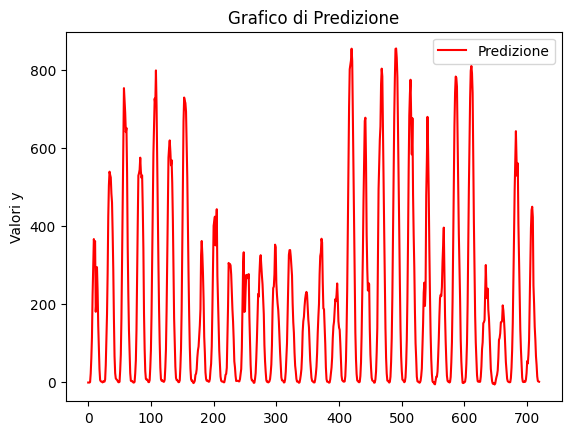

In [ ]:
plt.plot(range(len(y_pred_A)), y_pred_A, label='Predizione', color='red', linestyle='-')

# Aggiungi una legenda
plt.legend()

# Aggiungi etichette agli assi
plt.ylabel('Valori y')

# Titolo del grafico
plt.title('Grafico di Predizione')

# Mostra il grafico
plt.show()

In [ ]:
df = pd.DataFrame({'Prediction':y_pred_A})

In [ ]:
threshold = 0.05
df['Prediction'] = df['Prediction'].apply(lambda x: 0 if x < threshold else x)

In [ ]:
df.to_csv('Catboost_A.csv')